In [1]:
using CellBasedModels
using CairoMakie
using Random
Makie.inline!(true);

┌ Warning: Error requiring `MakieCore` from `Polynomials`
│   exception =
│    LoadError: ArgumentError: Package Polynomials does not have MakieCore in its dependencies:
│    - You may have a partially installed environment. Try `Pkg.instantiate()`
│      to ensure all packages in the environment are installed.
│    - Or, if you have Polynomials checked out for development and have
│      added MakieCore as a dependency but haven't updated your primary
│      environment's manifest file, try `Pkg.resolve()`.
│    - Otherwise you may need to report an issue with Polynomials
│    Stacktrace:
│      [1] macro expansion
│        @ ./loading.jl:1167 [inlined]
│      [2] macro expansion
│        @ ./lock.jl:223 [inlined]
│      [3] require(into::Module, mod::Symbol)
│        @ Base ./loading.jl:1144
│      [4] include(mod::Module, _path::String)
│        @ Base ./Base.jl:419
│      [5] include(x::String)
│        @ Polynomials ~/.julia/packages/Polynomials/6i39P/src/Polynomials.jl:6
│      [

In [2]:
include("physiCell.jl");
include("utils.jl");

# Functions

In [3]:
function setupPhysiCell!(com, parameters=PhysiCell.parameters; init_volumes=false, ratio_volume_target = 2, init_ratio=true)

    for p in keys(parameters)
        if p in keys(com.parameters)
            com[p] .= parameters[p]
        end
    end

    if !init_volumes && any(PhysiCell.f_v.(com.vF,com.vNS,com.vCS) .≈ 0.)
        print("WARNING. Some cells have volume zero. Maybe you forgot to set them up. Set `init_volumes=true` if you want automatically setting up them with default parameters.")
    elseif init_volumes
        com.vNS .= parameters[:vNSTarget]/ratio_volume_target
        com.vCS .= PhysiCell.f_vCSTarget(parameters[:fCN],com.vNS)/ratio_volume_target
        com.vF .= parameters[:fF]*parameters[:v]/ratio_volume_target
    end
    if init_ratio && :r in keys(com.parameters)
        com.r .= PhysiCell.f_r.(com.vF,com.vNS,com.vCS)
    end
    
end

setupPhysiCell! (generic function with 2 methods)

In [4]:
function plot_volume(com; size=(100,30), n=[1,2], stripe_size=5)

    d = getParameter(com,[:t,:id,:vF,:vCS,:vNS, :cycle])
    fig = Figure(size=size)
    ax = Axis(fig[1,1])
    for id in n
        ids = [id in i for i in d[:id]]
        pos = findfirst(d[:id][ids][1].==id)
        
        t = d[:t][ids]
        vNS = [i[pos] for i in d[:vNS][ids]]
        vCS = [i[pos] for i in d[:vCS][ids]]
        vF = [i[pos] for i in d[:vF][ids]]
        cycle = [i[pos] for i in d[:cycle][ids]]
        
        band!(ax,t,zeros(length(vNS)),vNS, color=:lightgreen)
        band!(ax,t,vNS,vNS.+vCS, color=:green)
        band!(ax,t,vNS.+vCS,vNS.+vCS.+vF, color=:orange)
        map = Dict(-1=>:gray,0=>:lightblue,1=>:blue,2=>:darkblue)
        band!(ax,t,-stripe_size .*ones(length(vNS)), 0 .*ones(length(vNS)), color=[map[i] for i in cycle])
    end

    return fig, ax
    
end

plot_volume (generic function with 1 method)

In [5]:
function plot_cells(com; times=[], show_ids=[], plane=[:x,:y], size=(400,400), alpha=(1,0.2,0.05))

    if times == []
        times = [1, length(com)]
    end

    if show_ids == []
        show_ids = range(1,maximum(com.id))
    end
    
    d = getParameter(com,[:t,:x,:y,:z,:id,:vF,:vCS,:vNS])
    fig = Figure(size=(size[1],size[2]*length(times)))
    for (pos,time) in enumerate(times)
        if length(plane) == 2
            ax = Axis3(fig[pos,1], aspect = :data, azimuth=0.5*π, elevation=π/2, zlabelvisible=false, zticklabelsvisible=false)
        elseif length(plane) == 3
            ax = Axis3(fig[pos,1], aspect = :data)            
        else
            throw(Exception("Argument `plane` should be of size 2 or 3."))
        end
        ids = [i in show_ids for i in d[:id][time]]
        
        vNS = d[:vNS][time][ids]
        vCS = d[:vCS][time][ids]
        vF = d[:vF][time][ids]
        rN = PhysiCell.f_r.(vNS, 0., 0.)
        r = PhysiCell.f_r.(vNS, vCS, vF)
        x = d[plane[1]][time][ids]
        y = d[plane[2]][time][ids]
        rmax = maximum(r)

        if length(plane) == 2
            meshscatter!(ax, x, y, markersize=rN, color=(:black,alpha[1]))
            meshscatter!(ax, x, y, markersize=r, color=(:blue,alpha[2]))
            meshscatter!(ax, x, y, markersize=com.ra.*r, color=(:blue,alpha[3]))
        else
            z = d[plane[3]][time][ids]
            meshscatter!(ax, x, y, z, markersize=rN, color=(:black,alpha[1]))
            meshscatter!(ax, x, y, z, markersize=r, color=(:blue,alpha[2]))
            meshscatter!(ax, x, y, z, markersize=com.ra.*r, color=(:blue,alpha[3]))    
            zlims!(ax, minimum(z)-com.ra[1]*rmax, maximum(z)+com.ra[1]*rmax)
        end
        xlims!(ax, minimum(x)-com.ra[1]*rmax, maximum(x)+com.ra[1]*rmax)
        ylims!(ax, minimum(y)-com.ra[1]*rmax, maximum(y)+com.ra[1]*rmax)
    end

    return fig
    
end

plot_cells (generic function with 1 method)

# Volume model & Cell Cycle models

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase ~/.julia/packages/SciMLBase/szsYq/src/performance_warnings.jl:32


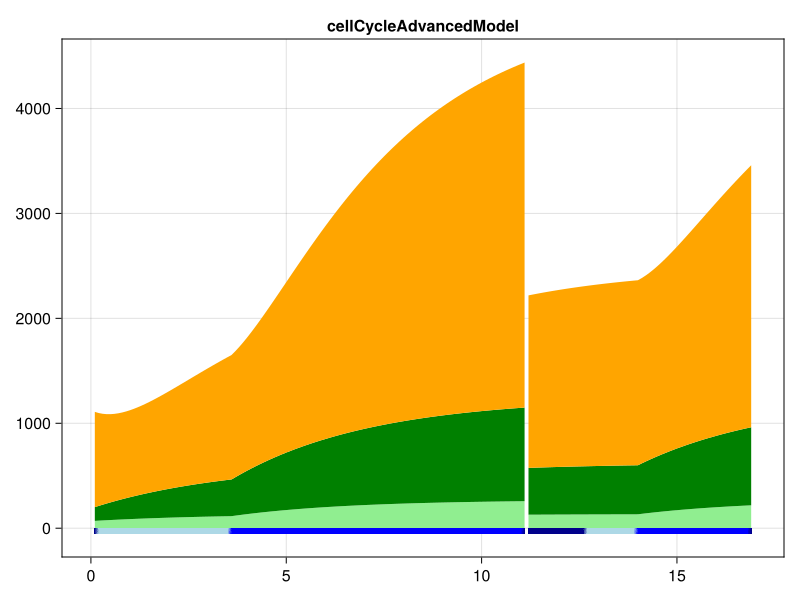

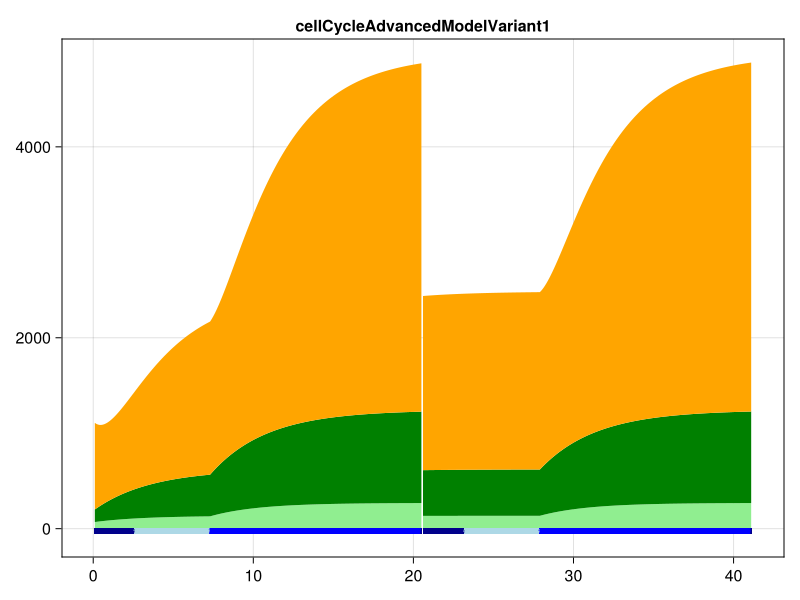

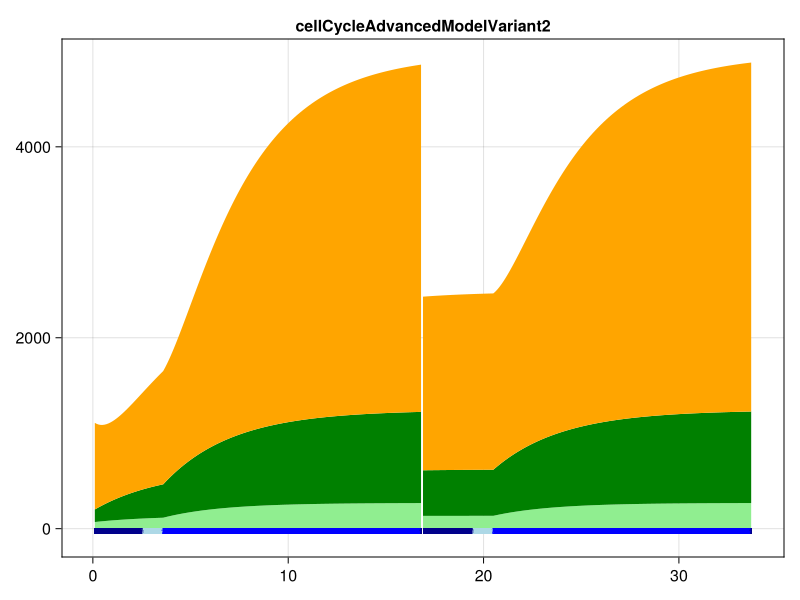

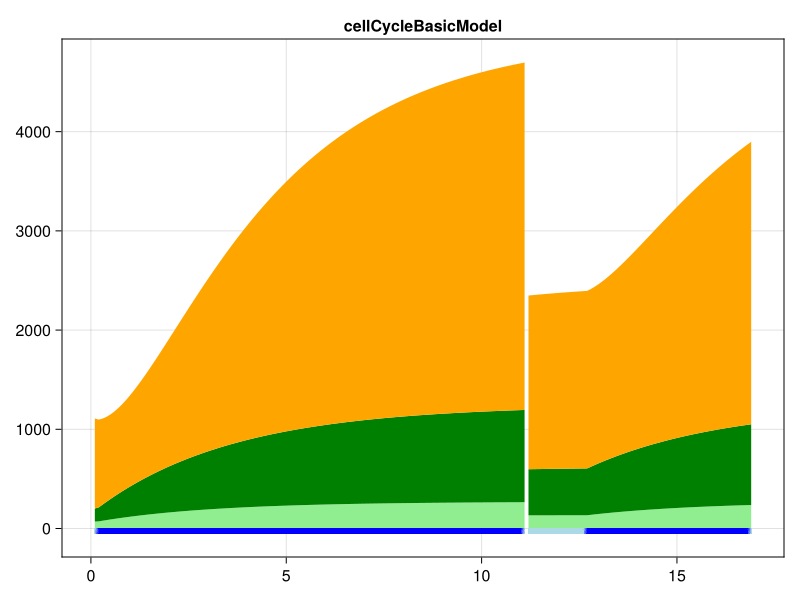

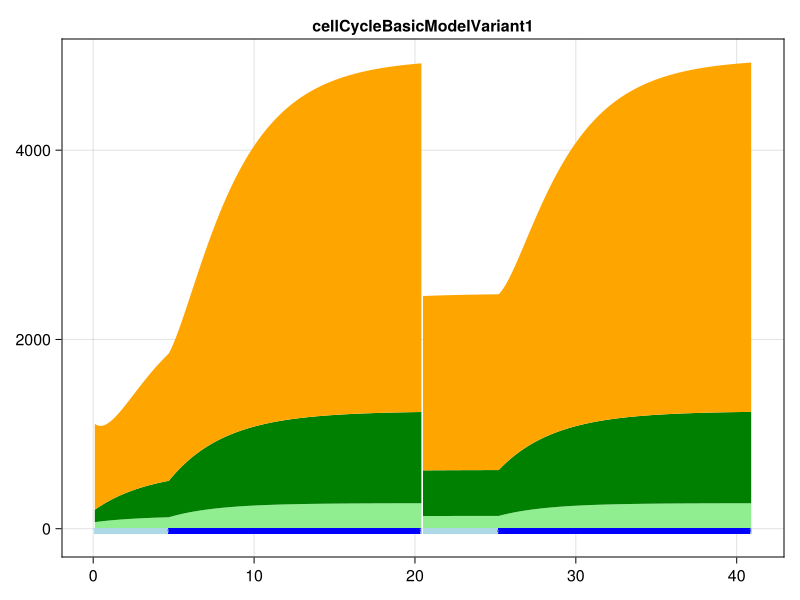

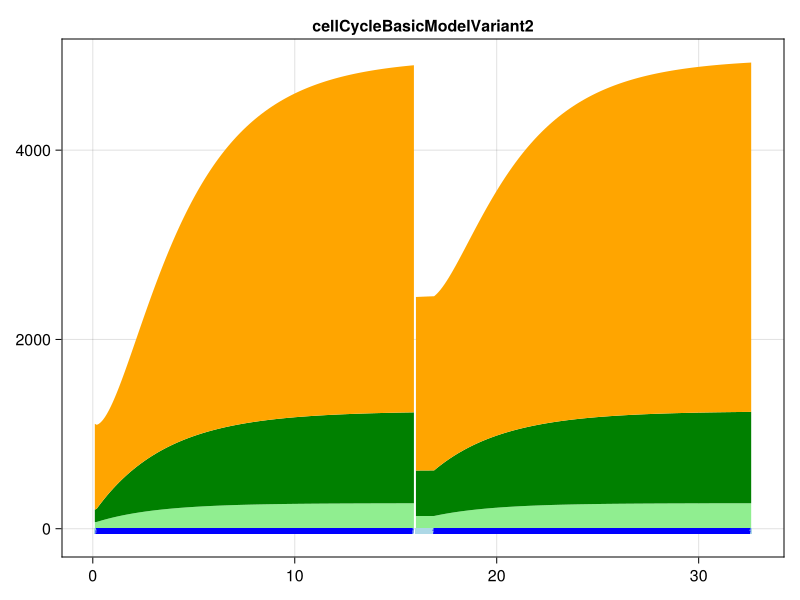

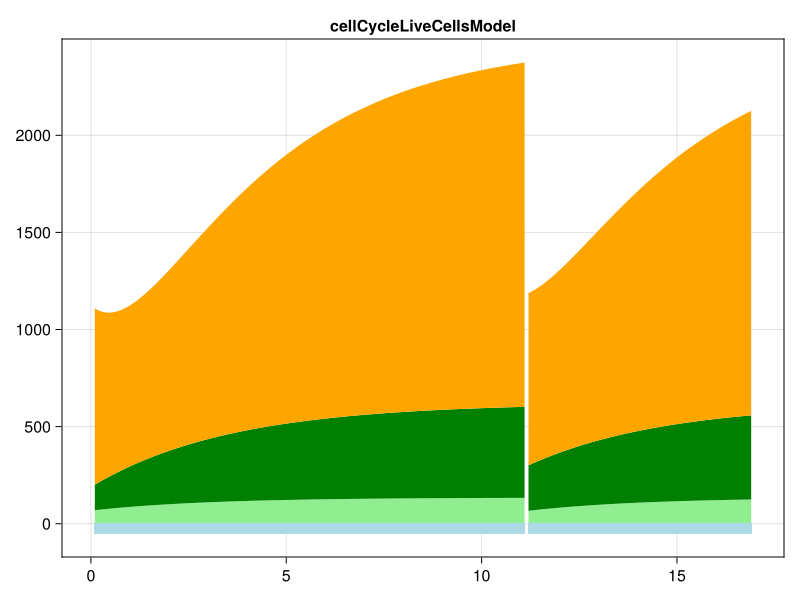

In [6]:
for (name, cellCycleModel, cycle) in 
    [
        ("cellCycleAdvancedModel", PhysiCell.cellCycleAdvancedModel, 2),
        ("cellCycleAdvancedModelVariant1", PhysiCell.cellCycleAdvancedModelVariant1, 2),
        ("cellCycleAdvancedModelVariant2", PhysiCell.cellCycleAdvancedModelVariant2, 2),
        ("cellCycleBasicModel", PhysiCell.cellCycleBasicModel, 0),
        ("cellCycleBasicModelVariant1", PhysiCell.cellCycleBasicModelVariant1, 0),
        ("cellCycleBasicModelVariant2", PhysiCell.cellCycleBasicModelVariant2, 0),
        ("cellCycleLiveCellsModel", PhysiCell.cellCycleLiveCellsModel, 0),
    ]

    Random.seed!(0)
    model = ABM(3,
        baseModelInit = [
            PhysiCell.volumeModel,
            cellCycleModel,
            PhysiCell.cellDivisionModel
        ]
    );

    com = Community(model, N=1, dt=0.1)
    com.cycle = cycle
    setupPhysiCell!(com, init_volumes=true)

    evolve!(com, steps=500, preallocateAgents=9)
    com.N

    fig, ax = plot_volume(com, stripe_size=50)
    ax.title = name
    display(fig)

end

# Death Models

WARNING. Some cells have volume zero. Maybe you forgot to set them up. Set `init_volumes=true` if you want automatically setting up them with default parameters.

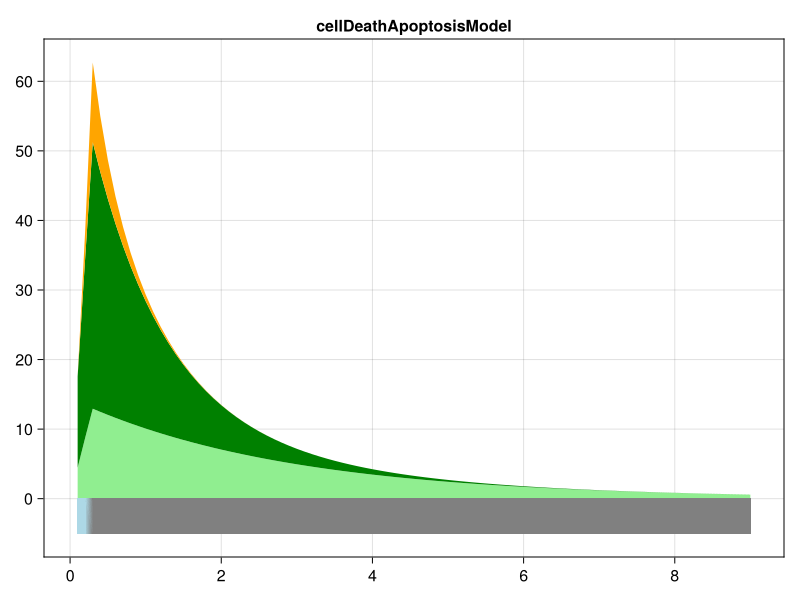

In [7]:
for (name, cellDeathModel, cycle) in 
    [
        ("cellDeathApoptosisModel", PhysiCell.cellDeathApoptosisModel, 2),
    ]

    Random.seed!(0)
    model = ABM(3,
        baseModelInit = [
            PhysiCell.volumeModel,
            PhysiCell.cellCycleLiveCellsModel,
            PhysiCell.cellDivisionModel,
            cellDeathModel,
        ]
    );

    com = Community(model, N=1, dt=0.1)
    setupPhysiCell!(com)
    #Custom initialization    
    com.rDeathApop = 0.8
#    com.tApop = 100

    evolve!(com, steps=100, preallocateAgents=9)

    fig, ax = plot_volume(com, n=[1], stripe_size=5)
    ax.title = name
    display(fig)

end

# Mechanics

In [8]:
include("physiCell.jl");
include("utils.jl");

## Cell interactions

In [9]:
model = ABM(3,
    baseModelInit = [
        PhysiCell.volumeModel,
        PhysiCell.cellMechanicsModelBegin,
        PhysiCell.cellMechanicsCellCellAdhesionModel,
        PhysiCell.cellMechanicsModelEnd
    ]
);

In [10]:
com = Community(model,N=2,dt=0.1/60)

setupPhysiCell!(com, init_volumes=true)
com.rF = 0
com.rC = 0
com.rN = 0

com.x .= [-4.,4.]
com.vF

2-element Vector{Float64}:
 935.25
 935.25

In [11]:
evolve!(com, steps=2000, preallocateAgents=100)

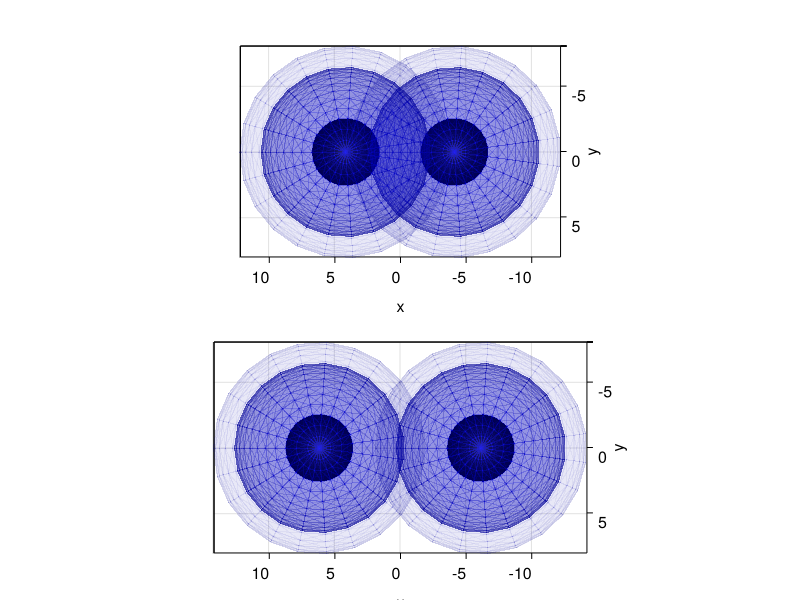

In [12]:
plot_cells(com, plane=[:x,:y])

## Cell division

In [29]:
model = ABM(3,
    baseModelInit = [
        PhysiCell.volumeModel,
        PhysiCell.cellCycleLiveCellsModel,
        PhysiCell.cellDivisionModel,
        PhysiCell.cellMechanicsModelBegin,
        PhysiCell.cellMechanicsCellCellAdhesionModel,
        PhysiCell.cellMechanicsModelEnd
    ],
    neighborsAlg=CBMNeighbors.CLVD(cellEdge=[10,10,10],skin=10,nMaxNeighbors=20)
);

In [53]:
com = Community(model,N=1,dt=0.1/60, simBox=[-300 300;-300 300;-300 300])

setupPhysiCell!(com, init_volumes=true)

1-element Vector{Float64}:
 6.450471028290378

In [54]:
function evolveCustom!(com,steps,preallocateAgents)
    loadToPlatform!(com, preallocateAgents=preallocateAgents) #Always necessary to load the parameters to the platform
    t = time()
    @time for i in 1:steps
        step!(com) #Always necessary to update the parameters at the end of all the steps.
        if i % 1000 == 0
            println("Step ", i, " N: ",com.N, " Δt: ", time()-t)
            t = time()
        end
        if com.N >= preallocateAgents
            print(step)
            break
        end
    end
    saveRAM!(com)
    bringFromPlatform!(com) #Always necessary to bring the data back to RAM after evolution lo unlock the agent.
end;

In [55]:
evolveCustom!(com, 200000, 3000)

Step 1000 N: 1 Δt: 0.3890380859375
Step 2000 N: 1 Δt: 0.384199857711792
Step 3000 N: 1 Δt: 0.3900911808013916
Step 4000 N: 1 Δt: 0.3849670886993408
Step 5000 N: 1 Δt: 0.3851630687713623
Step 6000 N: 1 Δt: 0.38633108139038086
Step 7000 N: 1 Δt: 0.4257071018218994
Step 8000 N: 1 Δt: 0.37898898124694824
Step 9000 N: 1 Δt: 0.37785911560058594
Step 10000 N: 1 Δt: 0.3788168430328369
Step 11000 N: 1 Δt: 0.3807830810546875
Step 12000 N: 1 Δt: 0.3862001895904541
Step 13000 N: 1 Δt: 0.38152599334716797
Step 14000 N: 2 Δt: 0.3862631320953369
Step 15000 N: 2 Δt: 0.38861703872680664
Step 16000 N: 2 Δt: 0.3869190216064453
Step 17000 N: 2 Δt: 0.38506007194519043
Step 18000 N: 2 Δt: 0.3865969181060791
Step 19000 N: 2 Δt: 0.38960909843444824
Step 20000 N: 2 Δt: 0.3883330821990967
Step 21000 N: 2 Δt: 0.387814998626709
Step 22000 N: 2 Δt: 0.3875579833984375
Step 23000 N: 2 Δt: 0.4356050491333008
Step 24000 N: 2 Δt: 0.3828299045562744
Step 25000 N: 2 Δt: 0.3817899227142334
Step 26000 N: 3 Δt: 0.3832519054

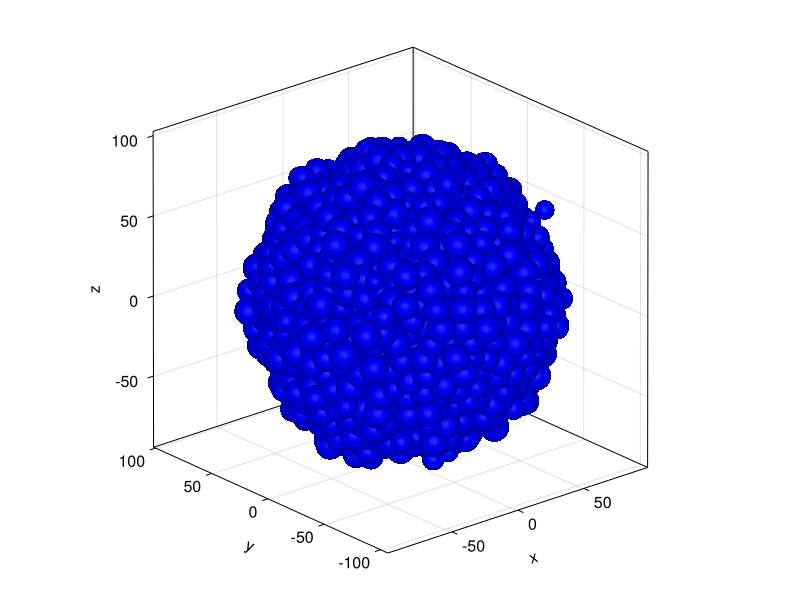

In [41]:
plot_cells(com, plane=[:x,:y,:z], alpha=(0,1,0), times=[1])

# Vein system

In [164]:
# Define the branching rules and grid
max_depth = 300
base_branch_length = 1.0
sparsity = 0.04  # Probability to generate a new branch
n_branches = 4
stop_ratio = 0.999
persistence = 0.7  # Persistence factor for branch direction

0.7

In [165]:
# Initialize the root point and direction
root_point = [50, 50, 0.0]
initial_direction = [0.0, 0.0, 1.0]

# Generate the fractal tree
Random.seed!(0)
nodes, edges = generate_fractal_tree(root_point, initial_direction, 0, 
    max_depth=max_depth, base_branch_length=base_branch_length, 
    sparsity=sparsity, persistence=persistence, n_branches=n_branches, stop_ratio=stop_ratio)

length(nodes)

4706

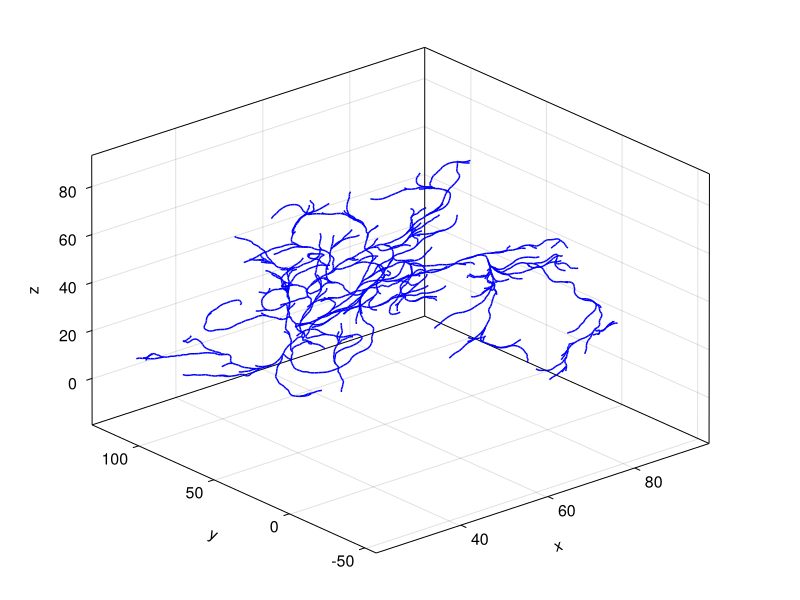

In [166]:
# Plot the tree using lines between nodes
f = Figure()
ax = Axis3(f[1,1])
for edge in edges
    p1, p2 = edge
    lines!(ax,[p1[1], p2[1]], [p1[2], p2[2]], [p1[3], p2[3]], color=:blue)
end

f

In [44]:
com = Community(model, N=10, dt=0.1)

Community with 10 agents.
